In [7]:
# Early WIP

In [8]:
# Standard imports
import os
import numpy as np
import pandas as pd
import quandl
from datetime import datetime
import pickle

# Plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from bokeh.plotting import figure, output_notebook, show, output_file
import seaborn as sns

# Housekeeping
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

plt.rcParams.update({
    'font.family': 'monospace',
    'font.size': 10,
    'figure.figsize': (12, 6),
})

# Colour management
MC = '#242a49'  # Main colour
SC = 'red'  # Secondary colour
grid_params = {'color': MC, 'alpha': .1}

output_notebook()
%matplotlib inline

Loading BokehJS ...

In [9]:
# Versions of packages
import pkg_resources
print(pkg_resources.get_distribution('numpy'))
print(pkg_resources.get_distribution('pandas'))
print(pkg_resources.get_distribution('quandl'))
print(pkg_resources.get_distribution('matplotlib'))

numpy 1.13.3
pandas 0.21.0
Quandl 3.2.1
matplotlib 2.0.2


In [21]:
import os

os.path.isfile('data/BCHARTS-KRAKENUSD.pkl')
# os.path.isdir('data')


True

In [26]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = 'data/' + '{}.pkl'.format(quandl_id).replace('/', '-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns='pandas')
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [27]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


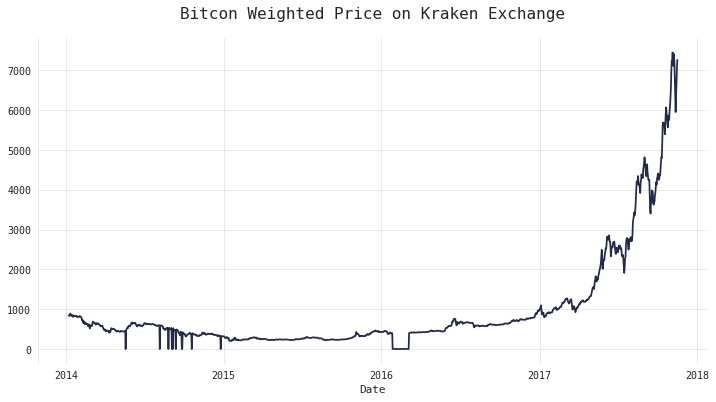

In [28]:
plt.figure(figsize=(12, 6))
plt.axes(frameon=False)
btc_usd_price_kraken['Weighted Price'].plot(ax=plt.gca(), color=MC)
plt.grid(**grid_params)
plt.title('Bitcon Weighted Price on Kraken Exchange', fontsize=16, y=1.04);

In [29]:
# Pull pricing data from more BTC exchanges
exchanges = ['COINBASE', 'BITSTAMP', 'ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [30]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [31]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), 
                                       list(exchange_data.keys()), 
                                       'Weighted Price')

In [32]:
btc_usd_datasets.tail(2)

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2017-11-15,"7,064.13","7,063.48","7,014.32","7,081.23"
2017-11-16,"7,294.79","7,294.00","7,292.97","7,260.60"


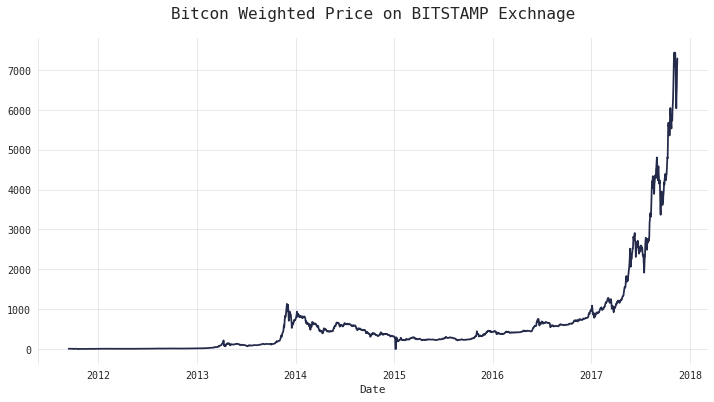

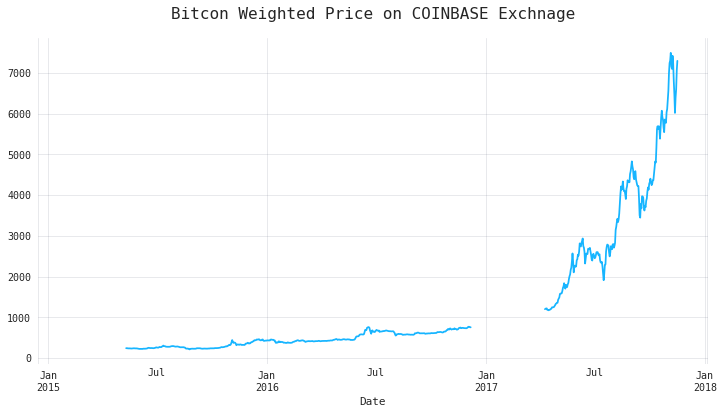

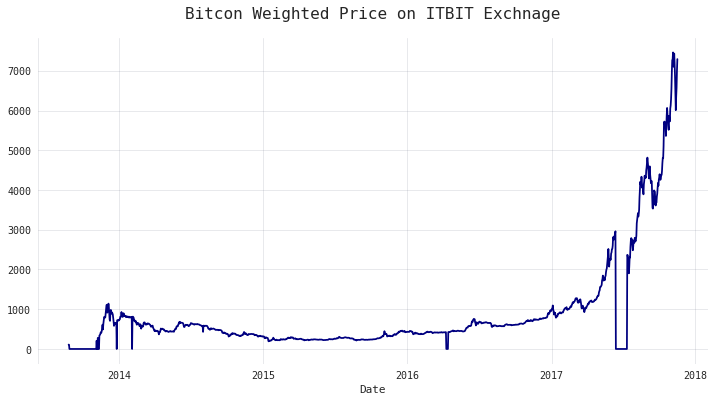

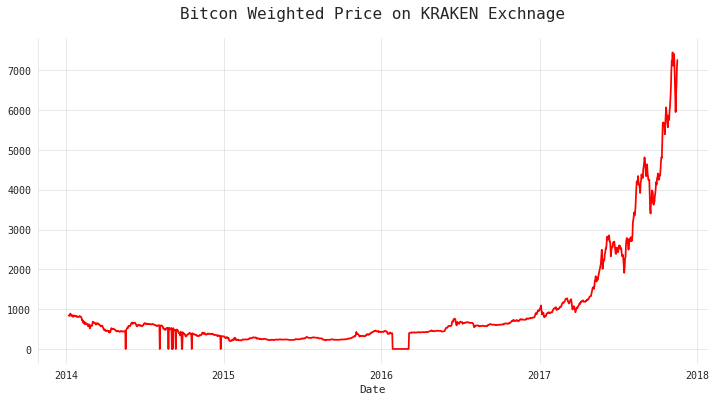

In [33]:
colors = [MC, '#17b5ff', 'navy', 'red']

for i, exchange in enumerate(btc_usd_datasets.columns):
    plt.figure(figsize=(12, 6))
    plt.axes(frameon=False)
    btc_usd_datasets[exchange].plot(ax=plt.gca(), color=colors[i])
    plt.grid(**grid_params)
    plt.title('Bitcon Weighted Price on {} Exchnage'.format(exchange), fontsize=16, y=1.04);

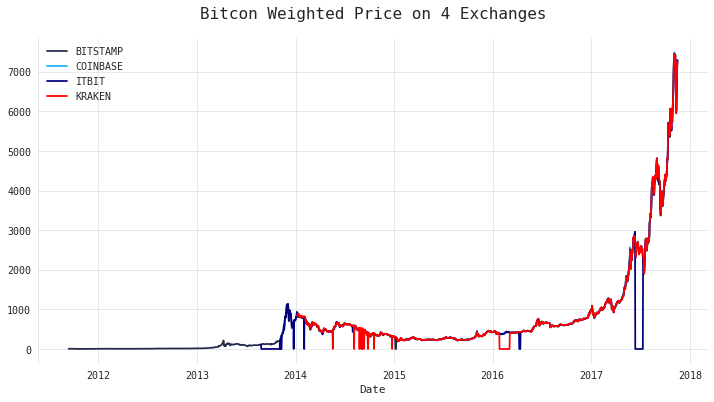

In [34]:
colors = [MC, '#17b5ff', 'navy', 'red']
plt.figure(figsize=(12, 6))
plt.axes(frameon=False)
btc_usd_datasets.plot(ax=plt.gca(), color=colors)
plt.grid(**grid_params)
plt.title('Bitcon Weighted Price on 4 Exchanges', fontsize=16, y=1.04);

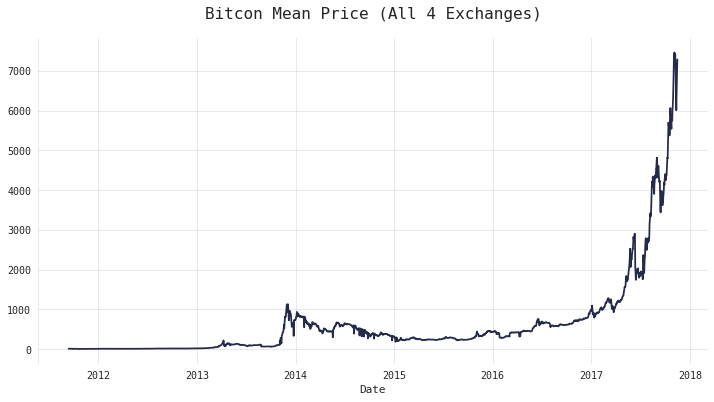

In [35]:
# Mean price on all 4 exchanges
plt.figure(figsize=(12, 6))
plt.axes(frameon=False)
btc_usd_datasets.mean(axis=1).plot(ax=plt.gca(), color=MC)
plt.grid(**grid_params)
plt.title('Bitcon Mean Price (All 4 Exchanges)', fontsize=16, y=1.04);

In [36]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:
        f = open('data/' + cache_path, 'rb')
        df = pickle.load(f)
        print('Loaded {} from cache\n'.format(json_url))
    except (OSError, IOError, FileNotFoundError) as e:
        print('Downloading {}\n'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle('data/' + cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [37]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.now()
period = 86400 # 86,400 seconds per day

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [38]:
altcoins = ['ETH', 'LTC', 'XRP', 'STR', 'DASH', 'SC', 'XMR', 'XEM']

altcoin_data = {}
for altcoin in altcoins:
    coin_pair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coin_pair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420066800.0&end=1511117895.014588&period=86400 from cache

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1420066800.0&end=1511117895.014588&per

In [39]:
altcoin_data['ETH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-11-14,0.05,0.05,0.05,0.05,"166,089.02","8,271.51",0.05
2017-11-15,0.05,0.05,0.04,0.05,"173,187.14","8,205.90",0.05
2017-11-16,0.04,0.05,0.04,0.05,"216,724.69","9,376.04",0.04
2017-11-17,0.04,0.04,0.04,0.04,"141,669.86","5,973.03",0.04
2017-11-18,0.04,0.04,0.04,0.04,"80,696.62","3,494.08",0.04


In [40]:
btc_usd_datasets.head()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2011-09-13,5.93,nan,nan,nan
2011-09-14,5.59,nan,nan,nan
2011-09-15,5.09,nan,nan,nan
2011-09-16,4.85,nan,nan,nan
2011-09-17,4.87,nan,nan,nan


In [41]:
# Calculate USD Price as a new column in each altcoin dataframe
btc_usd_datasets.replace(0, np.nan, inplace=True)
btc_avg_price = btc_usd_datasets.mean(axis=1)
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] = altcoin_data[altcoin]['weightedAverage'] * btc_avg_price

In [42]:
# Merge USD price of each altcoin into single df
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [43]:
# Add BTC price to the df
combined_df['BTC'] = btc_avg_price

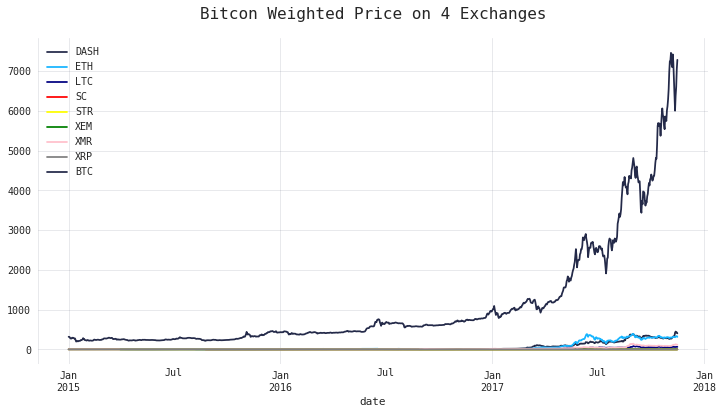

In [51]:
# Chart all of the altcoin prices
colors = [MC, '#17b5ff', 'navy', 'red', 'yellow', 'green', 'pink', 'grey']
plt.figure(figsize=(12, 6))
plt.axes(frameon=False)
combined_df.plot(ax=plt.gca(), color=colors)
plt.grid(**grid_params)
plt.title('Bitcon Weighted Price on 4 Exchanges', fontsize=16, y=1.04);

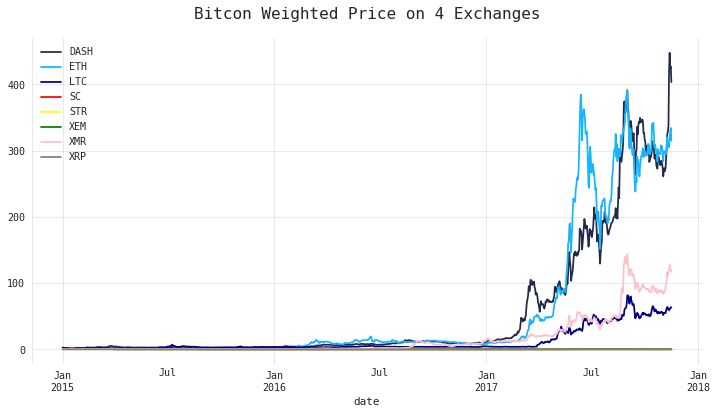

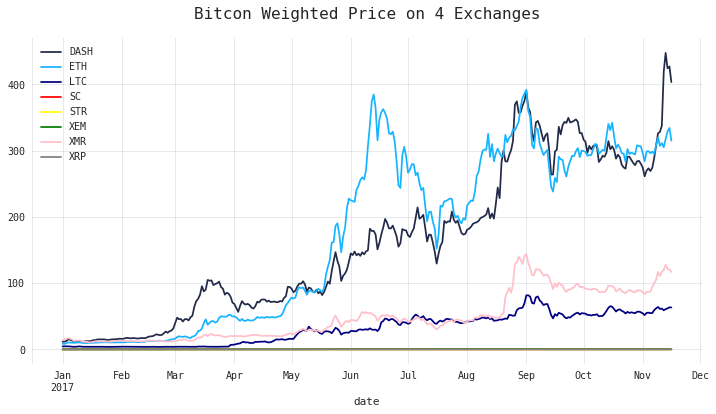

In [61]:
all_2017_df = combined_df.loc['2017':, :]
# Chart of altcoins without BTC
colors = [MC, '#17b5ff', 'navy', 'red', 'yellow', 'green', 'pink', 'grey']
plt.figure(figsize=(12, 6))
plt.axes(frameon=False)
all_2017_df.drop('BTC', axis=1).plot(ax=plt.gca(), color=colors)
plt.grid(**grid_params)
plt.title('Bitcon Weighted Price on 4 Exchanges', fontsize=16, y=1.04);

In [63]:
# Calculate the pearson correlation coefficients for cryptocurencies in 2017
all_2017_df.pct_change().corr(method='pearson')

,DASH,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
DASH,1.00,0.49,0.30,0.23,0.17,0.32,0.47,0.08,0.32
ETH,0.49,1.00,0.36,0.37,0.26,0.39,0.56,0.17,0.45
LTC,0.30,0.36,1.00,0.34,0.32,0.30,0.43,0.35,0.41
SC,0.23,0.37,0.34,1.00,0.42,0.34,0.34,0.26,0.35
STR,0.17,0.26,0.32,0.42,1.00,0.39,0.30,0.54,0.19
XEM,0.32,0.39,0.30,0.34,0.39,1.00,0.34,0.28,0.37
XMR,0.47,0.56,0.43,0.34,0.30,0.34,1.00,0.24,0.39
XRP,0.08,0.17,0.35,0.26,0.54,0.28,0.24,1.00,0.20
BTC,0.32,0.45,0.41,0.35,0.19,0.37,0.39,0.20,1.00


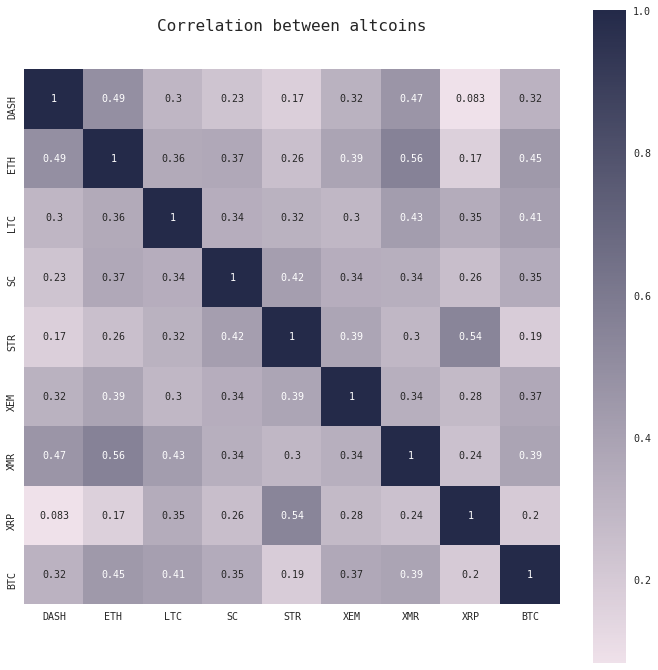

In [81]:
cmap = mcolors.LinearSegmentedColormap.from_list('n', ['white', MC])
cmap = mcolors.LinearSegmentedColormap.from_list('n', ['#efe1ea', MC])
plt.figure(figsize=(12, 12))
sns.heatmap(all_2017_df.pct_change().corr(method='pearson'),
           square=True,
           annot=True,
           cmap=cmap);
plt.title('Correlation between altcoins', fontsize=16, y=1.06);